In [1]:
import numpy as np
from pathlib import Path
import time
import matplotlib.pyplot as plt
start_time = time.time()

import xobjects as xo
import xtrack as xt
import xpart as xp
import xobjects as xo
import xcoll as xc

import apertls
from matplotlib.colors import LogNorm

In [2]:
line = xt.Line.from_json('../injection_lines/sps_with_aperture_inj_q20_beam_sagitta.json')

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           


In [3]:
env = line.env

line['adh.11207'] = 1e-6
line['adh.11407'] = 1e-6
line['adh.11607'] = 1e-6

In [4]:
opt = line.match(
    solve=False, # <--
    method='6d',
    vary=[
        xt.VaryList(['adh.11207', 'adh.11407', 'adh.11607'], step=1e-8, tag='correctors',)
    ],
    targets = [
        xt.TargetSet(x=-6.5e-3, at='tidp.11434..1')
    ])

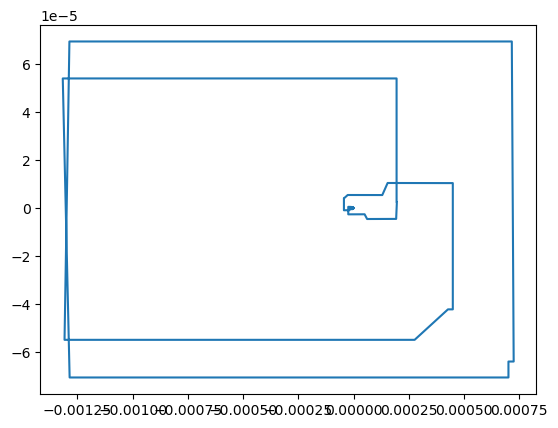

In [5]:
tw = line.twiss()

plt.figure()
plt.plot(tw.x, tw.px)